In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import pandas as pd
import os
import tensorflow.keras.losses
import math
import datetime
from my_classes import DataGenerator,STMImage
from scipy.ndimage.filters import gaussian_filter

In [3]:
model_name='run7_09_newarch'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 16)   160         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   4640        max_pooling2d_3[0][0]            
____________________________________________________________________________________________

(-0.5, 31.5, 31.5, -0.5)

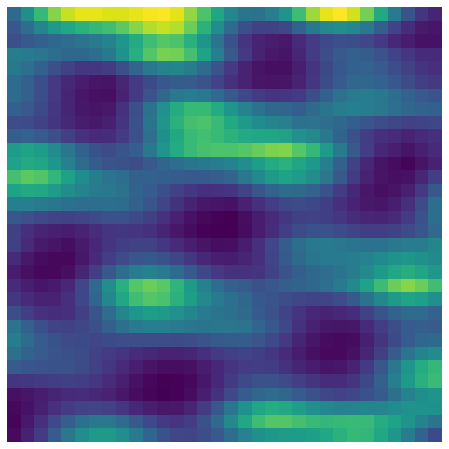

In [7]:
#ARRAY:Loads in a single testing image and plots its prediction vs true labels
#Method for separting label array into useful data points
def split_label(labels):
    center_atom=np.array([labels[0],labels[1]])*32
    neighborvec1=np.array([labels[2],labels[3]])*32
    neighborvec2=np.array([labels[4],labels[5]])*32
    neighborvec3=np.array([labels[6],labels[7]])*32
    neighbors=[]
    neighbors.append(center_atom+neighborvec1)
    neighbors.append(center_atom+neighborvec2)
    neighbors.append(center_atom+neighborvec3)
    return center_atom , neighbors 
#Methods for coloring in the central atom and labels on the images.
def plot_labels():
    plt.plot(center_atom[0],center_atom[1],'o',color='black')
    plt.plot(neighbors[0][0],neighbors[0][1],'o',color='red')
    plt.plot(neighbors[1][0],neighbors[1][1],'o',color='green')
    plt.plot(neighbors[2][0],neighbors[2][1],'o',color='blue')
def plot_test_labels():
    plt.plot(center_atom_t[0],center_atom_t[1],'o',color='xkcd:gray')
    plt.plot(neighbors_t[0][0],neighbors_t[0][1],'o',color='xkcd:dark red')
    plt.plot(neighbors_t[1][0],neighbors_t[1][1],'o',color='xkcd:dark green')
    plt.plot(neighbors_t[2][0],neighbors_t[2][1],'o',color='xkcd:dark blue')
def data_aug(data): #Performs data aumentation before being fed into batch
#     #Standardization
#     data -= np.mean(data)
#     data /= np.std(data)
    
    #Divide out the max
    data -= np.mean(data)
    data_max=np.max(data)
    data /= data_max
        
    data=np.reshape(data,(32,32,1))
    return data


    

model_name='run7_09_newarch'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_7_07'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))


    


index=21642
im_filename=dft['filename'][index]
atom_size=dft['atom_size'][index]
corr=dft['corr'][index]+.1
len_scale=np.array([dft['bl'].loc[index]])
#test_im=np.asarray(image.load_img(os.path.join(test_dataset_dir,im_filename)))
test_im=np.load(os.path.join(test_dataset_dir,im_filename))
batch_stm= data_aug(test_im)
batch_stm=np.expand_dims(batch_stm, axis=0)
batch_stm=[batch_stm,len_scale]

# label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
# test_labels=dft[label_names].loc[index].to_numpy()


# center_atom_t,neighbors_t=split_label(test_labels)
# center_atom,neighbors=split_label(prediction_labels)

#os.makedirs(os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d")))
# prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

# %matplotlib notebook
# %matplotlib inline


fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.matshow(test_im)
ax.axis('off')
#plot_test_labels()
#plot_labels()


# im_tensor=STMImage(test_im).image
# im_tensor=np.expand_dims(im_tensor, axis=0)

In [14]:
layer_outputs=[layer.output for layer in model.layers[:9]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(batch_stm)

In [15]:
model_name='run7_09_newarch'
plot_dir=os.path.join("Layer Activations",model_name)
#os.makedirs(plot_dir)
layer_names = []                                                          
for layer in model.layers[:9]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

plt.figure()
for layer_name, layer_activation in zip(layer_names, activations):      
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.savefig(os.path.join(plot_dir,'run7_09_newarch'+layer_name+'.png'))

    


ValueError: figure size must be positive finite not (16.0, 0.0)

<Figure size 432x288 with 0 Axes>